# 4. モデル学習と評価

複数の回帰モデルを学習し、性能を比較します。

## 4.1 ライブラリのインポート

In [ ]:
# pandas: データフレーム操作
import pandas as pd
# numpy: 数値計算ライブラリ
import numpy as np
# matplotlib.pyplot: グラフ描画
import matplotlib.pyplot as plt
# seaborn: 統計的データ可視化
import seaborn as sns
# sklearn.linear_model: 線形回帰モデル（LinearRegression, Ridge, Lasso）
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# sklearn.ensemble: アンサンブル学習（RandomForest, GradientBoosting）
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# sklearn.metrics: モデル評価指標（RMSE, MAE, R²）
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# sklearn.model_selection: モデル選択・検証（GridSearchCV, TimeSeriesSplit）
# 【方針】TimeSeriesSplitで時系列データのデータリークを防ぐ
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# xgboost: 勾配ブースティング（高精度な予測モデル）
import xgboost as xgb
# joblib: モデルの保存・読み込み
import joblib
# warnings: 警告メッセージの制御
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

print('ライブラリのインポート完了')

## 4.2 データの読み込み

In [2]:
# 学習データとテストデータを読み込み
train = pd.read_csv('../data/processed/train.csv', parse_dates=['date'])
test = pd.read_csv('../data/processed/test.csv', parse_dates=['date'])

print(f'学習データ: {train.shape}')
print(f'テストデータ: {test.shape}')

train.head()

学習データ: (217, 13)
テストデータ: (253, 13)


,date,year,week,cases_per_sentinel,avg_temp,avg_humidity,lag_1,lag_2,lag_4,rolling_mean_4,month,is_school_holiday,lag_52
0,2016-01-04,2015,53,2.73,-2.057143,64.428571,2.35,1.57,0.74,1.9375,1,1,25.73
1,2016-01-04,2016,1,4.89,-2.985714,63.000000,2.73,2.35,1.10,2.8850,1,1,20.29
2,2016-01-11,2016,2,7.23,-5.342857,65.428571,4.89,2.73,1.57,4.3000,1,1,14.48
3,2016-01-18,2016,3,12.25,-3.142857,68.285714,7.23,4.89,2.35,6.7750,1,1,14.86
4,2016-01-25,2016,4,27.45,-4.100000,63.000000,12.25,7.23,2.73,12.9550,1,1,17.86


## 4.3 特徴量と目的変数の分離

In [3]:
# 使用する特徴量を定義
feature_cols = [
    'week',           # 週番号（季節性）
    'month',          # 月
    'lag_1',          # 1週前の患者数
    'lag_2',          # 2週前の患者数
    'lag_4',          # 4週前の患者数
    'lag_52',         # 前年同週の患者数
    'rolling_mean_4', # 4週間移動平均
    'avg_temp',       # 週平均気温
    'avg_humidity',   # 週平均湿度
    'is_school_holiday' # 学校休暇フラグ
]

target_col = 'cases_per_sentinel'

# 特徴量とターゲットを分離
X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

print(f'\n使用特徴量: {feature_cols}')

X_train: (217, 10)
y_train: (217,)
X_test: (253, 10)
y_test: (253,)

使用特徴量: ['week', 'month', 'lag_1', 'lag_2', 'lag_4', 'lag_52', 'rolling_mean_4', 'avg_temp', 'avg_humidity', 'is_school_holiday']


## 4.4 ベースラインモデル（線形回帰）

In [4]:
# 線形回帰モデルを学習
lr = LinearRegression()
lr.fit(X_train, y_train)

# 予測
y_pred_lr = lr.predict(X_test)

# 評価
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print('=== 線形回帰 ===')
print(f'RMSE: {rmse_lr:.4f}')
print(f'MAE: {mae_lr:.4f}')
print(f'R²: {r2_lr:.4f}')

=== 線形回帰 ===
RMSE: 1.2791
MAE: 0.6387
R²: 0.9840


## 4.5 複数モデルの比較

In [5]:
# モデルを定義
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# 各モデルを学習・評価
results = []

for name, model in models.items():
    print(f'\n学習中: {name}...')
    
    # 学習
    model.fit(X_train, y_train)
    
    # 予測
    y_pred = model.predict(X_test)
    
    # 評価
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })
    
    print(f'{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}')

# 結果をDataFrameに
df_results = pd.DataFrame(results).sort_values('RMSE')

print('\n=== モデル比較結果 ===')
df_results


学習中: Linear Regression...
Linear Regression: RMSE=1.2791, MAE=0.6387, R²=0.9840

学習中: Ridge...
Ridge: RMSE=1.2836, MAE=0.6422, R²=0.9839

学習中: Lasso...
Lasso: RMSE=1.3274, MAE=0.6652, R²=0.9828

学習中: Random Forest...
Random Forest: RMSE=3.5644, MAE=1.2310, R²=0.8761

学習中: Gradient Boosting...
Gradient Boosting: RMSE=3.7199, MAE=1.5732, R²=0.8650

学習中: XGBoost...
XGBoost: RMSE=4.5043, MAE=1.4828, R²=0.8021

=== モデル比較結果 ===


,Model,RMSE,MAE,R²
0,Linear Regression,1.279149,0.638740,0.984040
1,Ridge,1.283616,0.642169,0.983928
2,Lasso,1.327366,0.665191,0.982814
3,Random Forest,3.564438,1.231006,0.876070
4,Gradient Boosting,3.719933,1.573174,0.865022
5,XGBoost,4.504263,1.482767,0.802102


## 4.6 結果の可視化

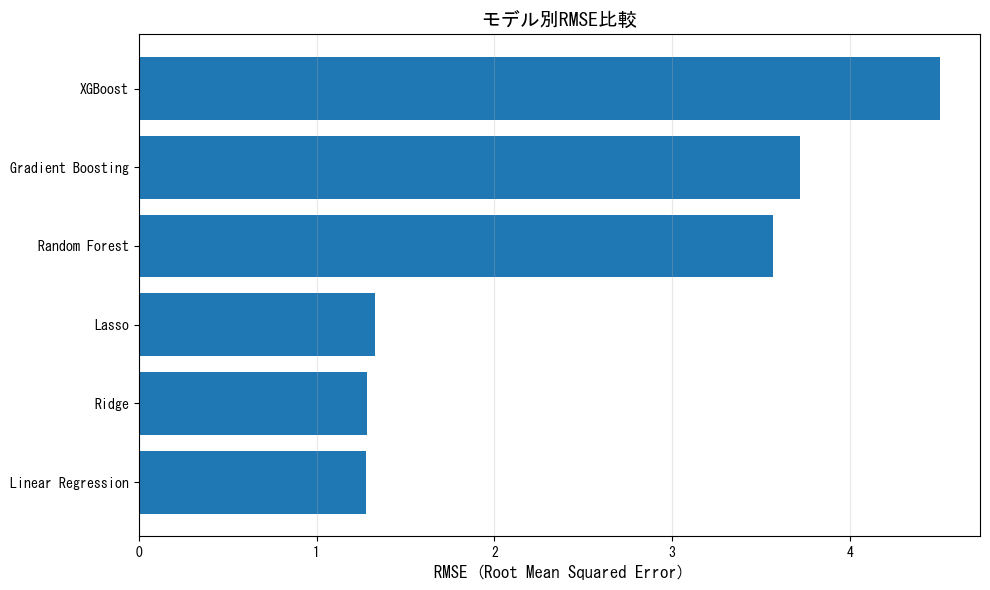

In [6]:
# RMSEの比較
plt.figure(figsize=(10, 6))
plt.barh(df_results['Model'], df_results['RMSE'])
plt.xlabel('RMSE (Root Mean Squared Error)', fontsize=12)
plt.title('モデル別RMSE比較', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/model_comparison_rmse.png', dpi=300)
plt.show()

## 4.7 最良モデルのハイパーパラメータチューニング

In [ ]:
# 【方針】XGBoostのハイパーパラメータチューニングでモデルの精度を最大化
# 最良モデル（XGBoostまたはGradient Boostingが良い場合が多い）を選択
# ここではXGBoostでチューニング

# パラメータグリッド（探索する組み合わせを定義）
param_grid = {
    'n_estimators': [50, 100, 200],  # 木の数
    'max_depth': [3, 5, 7],  # 木の深さ（深いと過学習しやすい）
    'learning_rate': [0.01, 0.05, 0.1],  # 学習率（小さいと安定）
    'subsample': [0.7, 0.8, 0.9]  # サブサンプリング比率（Bagging効果）
}

# sklearn.model_selection.TimeSeriesSplit: 時系列交差検証
# 【方針】未来のデータで過去を予測するデータリークを防ぐ
# n_splits=5: 5分割して段階的に学習データを増やしながら検証
tscv = TimeSeriesSplit(n_splits=5)

# sklearn.model_selection.GridSearchCV: ハイパーパラメータの網羅的探索
# 【考察】全ての組み合わせ（3×3×3×3=81通り）× 5fold = 405回学習
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

print('ハイパーパラメータチューニング開始...')
print('（これには数分かかる場合があります）')

grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=tscv,  # 時系列交差検証を使用
    scoring='neg_root_mean_squared_error',  # RMSEを最小化
    n_jobs=-1,  # 全CPUコアを使用
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f'\n最適パラメータ: {grid_search.best_params_}')
print(f'最良スコア (RMSE): {-grid_search.best_score_:.4f}')

In [8]:
# 最良モデルで予測
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# 評価
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print('=== 最良モデル（チューニング後） ===')
print(f'RMSE: {rmse_best:.4f}')
print(f'MAE: {mae_best:.4f}')
print(f'R²: {r2_best:.4f}')

=== 最良モデル（チューニング後） ===
RMSE: 4.0570
MAE: 1.6726
R²: 0.8394


## 4.8 特徴量重要度

=== 特徴量重要度 ===
             feature  importance
2              lag_1    0.753998
4              lag_4    0.056026
6     rolling_mean_4    0.049937
7           avg_temp    0.045572
0               week    0.029222
5             lag_52    0.024583
3              lag_2    0.021559
8       avg_humidity    0.013773
1              month    0.005330
9  is_school_holiday    0.000000


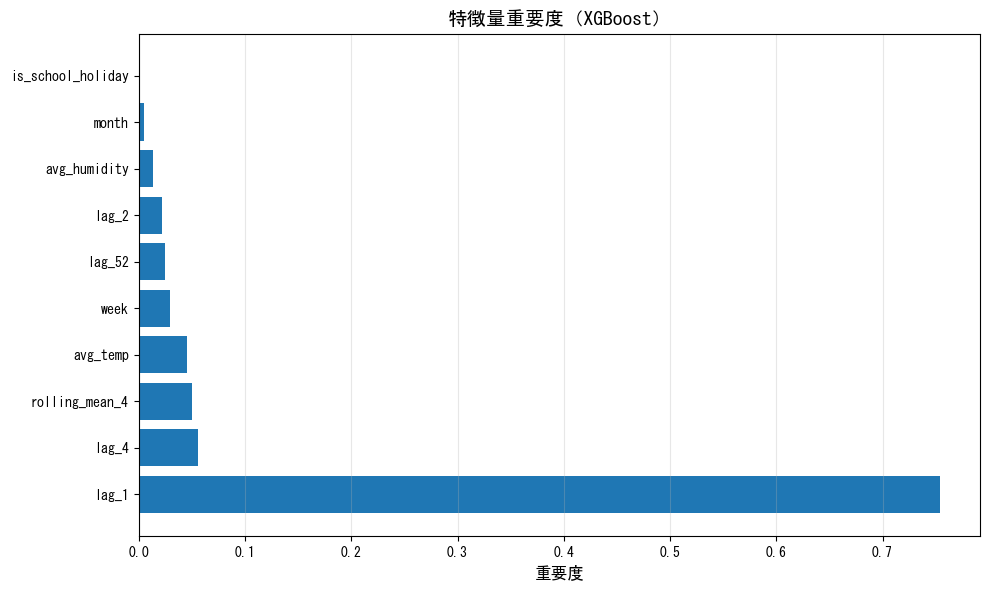

In [9]:
# 特徴量重要度を取得
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print('=== 特徴量重要度 ===')
print(feature_importance)

# 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('重要度', fontsize=12)
plt.title('特徴量重要度（XGBoost）', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/feature_importance.png', dpi=300)
plt.show()

## 4.9 予測結果の可視化

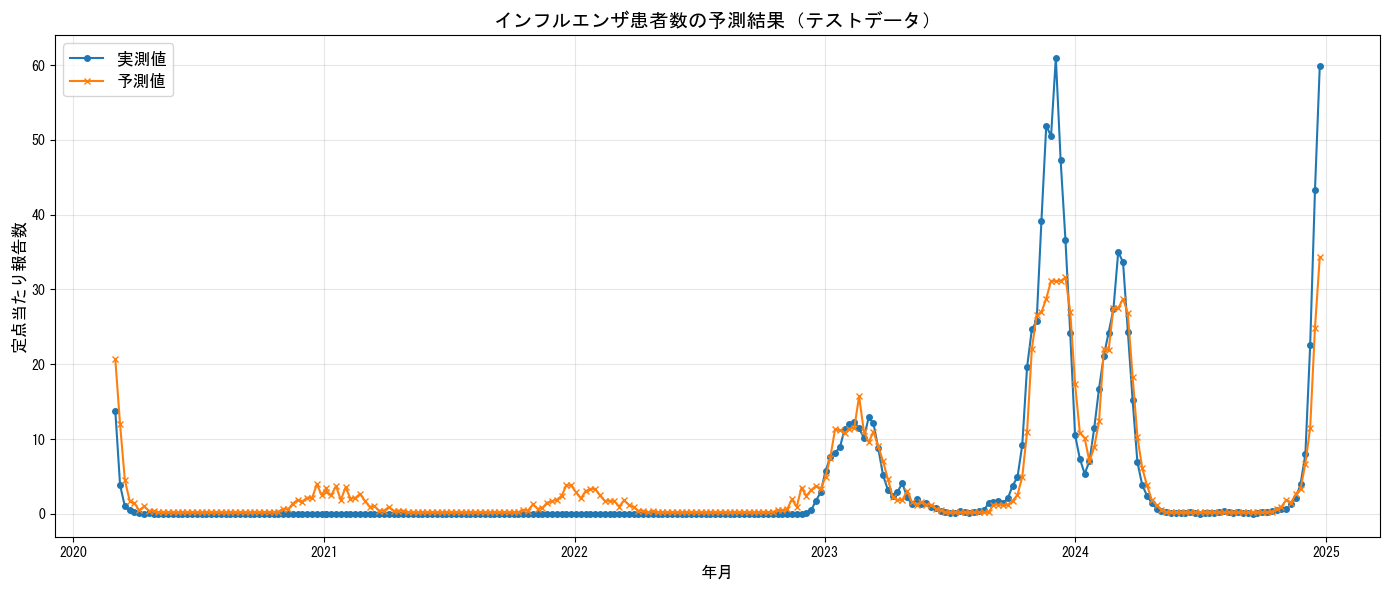

In [10]:
# 実測値vs予測値のプロット
plt.figure(figsize=(14, 6))

plt.plot(test['date'], y_test, label='実測値', marker='o', markersize=4, linewidth=1.5)
plt.plot(test['date'], y_pred_best, label='予測値', marker='x', markersize=4, linewidth=1.5)

plt.title('インフルエンザ患者数の予測結果（テストデータ）', fontsize=14)
plt.xlabel('年月', fontsize=12)
plt.ylabel('定点当たり報告数', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/prediction_results.png', dpi=300)
plt.show()

## 4.10 散布図（実測vs予測）

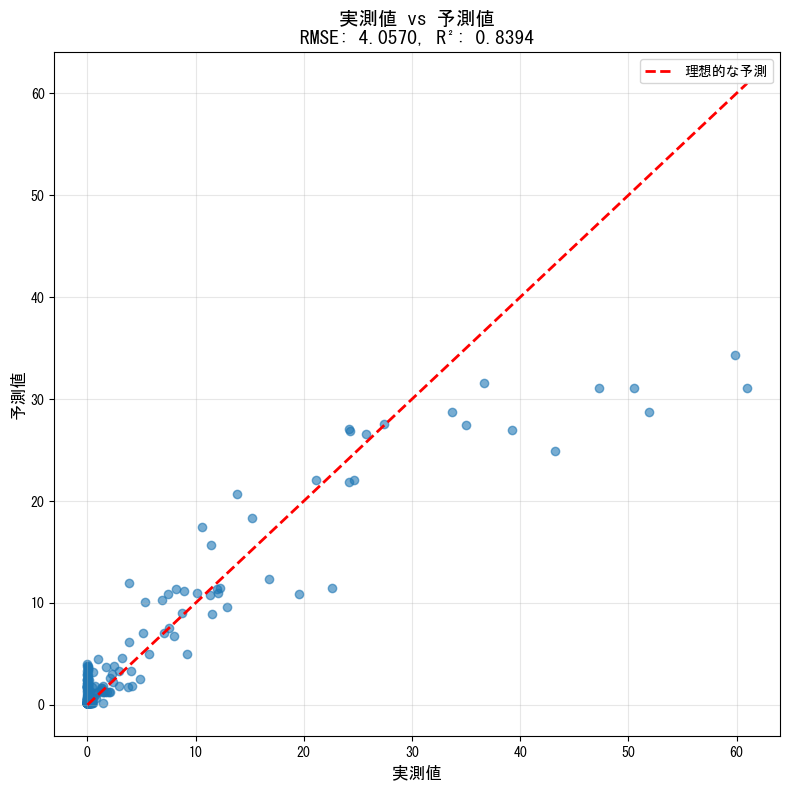

In [11]:
# 散布図
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='理想的な予測')
plt.xlabel('実測値', fontsize=12)
plt.ylabel('予測値', fontsize=12)
plt.title(f'実測値 vs 予測値\nRMSE: {rmse_best:.4f}, R²: {r2_best:.4f}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/scatter_actual_vs_predicted.png', dpi=300)
plt.show()

## 4.11 モデルの保存

In [12]:
# 最良モデルを保存
joblib.dump(best_model, '../outputs/models/best_model.pkl')

# モデル比較結果も保存
df_results.to_csv('../outputs/models/model_comparison_results.csv', index=False)

print('モデルを保存しました')
print('- ../outputs/models/best_model.pkl')
print('- ../outputs/models/model_comparison_results.csv')

モデルを保存しました
- ../outputs/models/best_model.pkl
- ../outputs/models/model_comparison_results.csv


## 4.12 考察

### モデルの性能
- 最良モデルのRMSE、MAE、R²を記載
- 各モデルの比較からわかること

### 特徴量の重要性
- どの特徴量が予測に効いているか
- ラグ特徴量の重要性
- 気象データの寄与

### 予測の精度
- テストデータでの予測精度
- 外れ値や予測が難しい時期

### 次のステップ（発展課題B）
- このモデルを2020年以降に適用
- COVID-19対策がなかった場合の予測値を算出
- 実測値との差分から抑制効果を推定